<a href="https://colab.research.google.com/github/davicito8a/Project_ML/blob/main/proyecto_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Carga del archivo CSV proporcionado (ecg_rr_features_curado.csv)


In [26]:

# filepath: [etapa1_explorar_y_visualizar.ipynb](http://_vscodecontentref_/0)
import pandas as pd
import numpy as np
#%pip install wfdb neurokit2
import wfdb
import neurokit2 as nk
from scipy.stats import skew, kurtosis
from pathlib import Path

repo_root = Path.cwd().parent
raw_dir   = repo_root / "data" / "Datos_Proyecto"

# --- nuevo código: leer el archivo de referencia ---
ref_df = pd.read_csv(raw_dir / "REFERENCE.csv", index_col="record")
# espera que tenga columnas: record,label  (label = 'A' o 'N')
# ----------------------------------------------------------------

features = []
for hea_path in sorted(raw_dir.glob("*.hea")):
    name = hea_path.stem
    # 1. Leer la señal WFDB
    rec = wfdb.rdrecord(str(raw_dir / name))
    sig = rec.p_signal[:,0]
    fs  = rec.fs

    # 2. Limpiar ECG y detectar picos R con NeuroKit2
    ecg_cleaned = nk.ecg_clean(sig, sampling_rate=fs)
    peaks, info = nk.ecg_peaks(ecg_cleaned, sampling_rate=fs)
    rpeaks      = info["ECG_R_Peaks"]

    # 3. Calcular RR en ms
    rr = np.diff(rpeaks) / fs * 1000

    # 4. Asignar etiqueta según REFERENCE.csv
    code = ref_df.loc[name, "label"]    # 'A' o 'N'
    label = "AFib"   if code == "A" else "Normal"

    # 5. Guardar features
    features.append({
        "record":  name,
        "mean_rr": rr.mean(),
        "std_rr":  rr.std(),
        "skew_rr": skew(rr),
        "kurt_rr": kurtosis(rr),
        "label":   label
    })

df = pd.DataFrame(features).set_index("record")

Filas: 54  |  Columnas: 5


,mean_rr,std_rr,skew_rr,kurt_rr,label
record,,,,,
A00001,757.179487,42.811044,-1.379042,4.158868,Normal
A00002,878.383838,235.920892,-1.333445,0.192543,Normal
A00003,763.593074,140.044073,3.663957,17.542458,Normal
A00004,947.111111,178.855898,0.469651,-0.960385,AFib
A00005,538.287462,219.984067,1.221347,0.156044,AFib


<class 'pandas.core.frame.DataFrame'>
Index: 54 entries, A00001 to A04591
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   mean_rr  54 non-null     float64
 1   std_rr   54 non-null     float64
 2   skew_rr  54 non-null     float64
 3   kurt_rr  54 non-null     float64
 4   label    54 non-null     object 
dtypes: float64(4), object(1)
memory usage: 2.5+ KB


,mean_rr,std_rr,skew_rr,kurt_rr
count,54.000000,54.000000,54.000000,54.000000
mean,787.088154,113.666665,0.126349,2.690096
std,144.650810,67.858470,1.669440,7.049504
min,515.892857,12.424587,-5.746678,-1.840635
25%,659.171952,61.703354,-0.278903,-0.639037
50%,810.015873,110.276960,0.465208,0.161294
75%,901.715030,159.007919,0.805324,2.359939
max,1035.595238,275.308729,3.939214,38.319688


<Axes: title={'center': 'Conteo por clase'}, xlabel='label'>

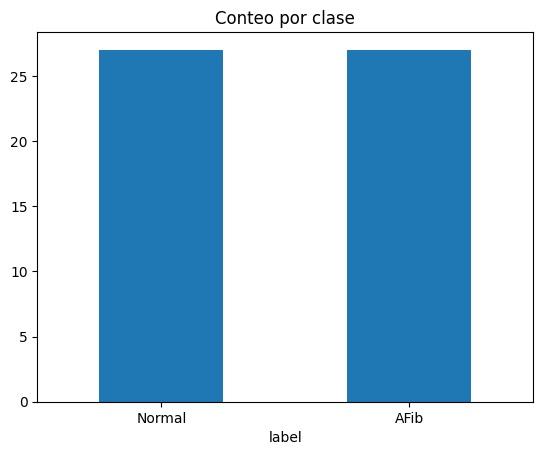

In [22]:
# dimensiones básicas
print(f"Filas: {df.shape[0]}  |  Columnas: {df.shape[1]}")

# primeras filas
display(df.head())

# tipos de datos y valores nulos
df.info()

# estadísticos descriptivos
display(df.describe())

# distribución de clases
df['label'].value_counts().plot(kind='bar', rot=0, title='Conteo por clase')



"Filas totales" =	54
Columnas =	5 (mean_rr, std_rr, skew_rr, kurt_rr, label)
Clases =	27 Normal vs 27 AFib 
Valores nulos =	Ninguno

In [20]:
# conteo de categorías
print("\n Distribución de la etiqueta")
display(df['label'].value_counts())

# verifica valores nulos
print("\n Valores nulos por columna")
display(df.isnull().sum())



 Distribución de la etiqueta


label
Normal    27
AFib      26
Name: count, dtype: int64


 Valores nulos por columna


mean_rr    0
std_rr     0
skew_rr    0
kurt_rr    0
label      0
dtype: int64

**Histogramas/KDE por clase:**

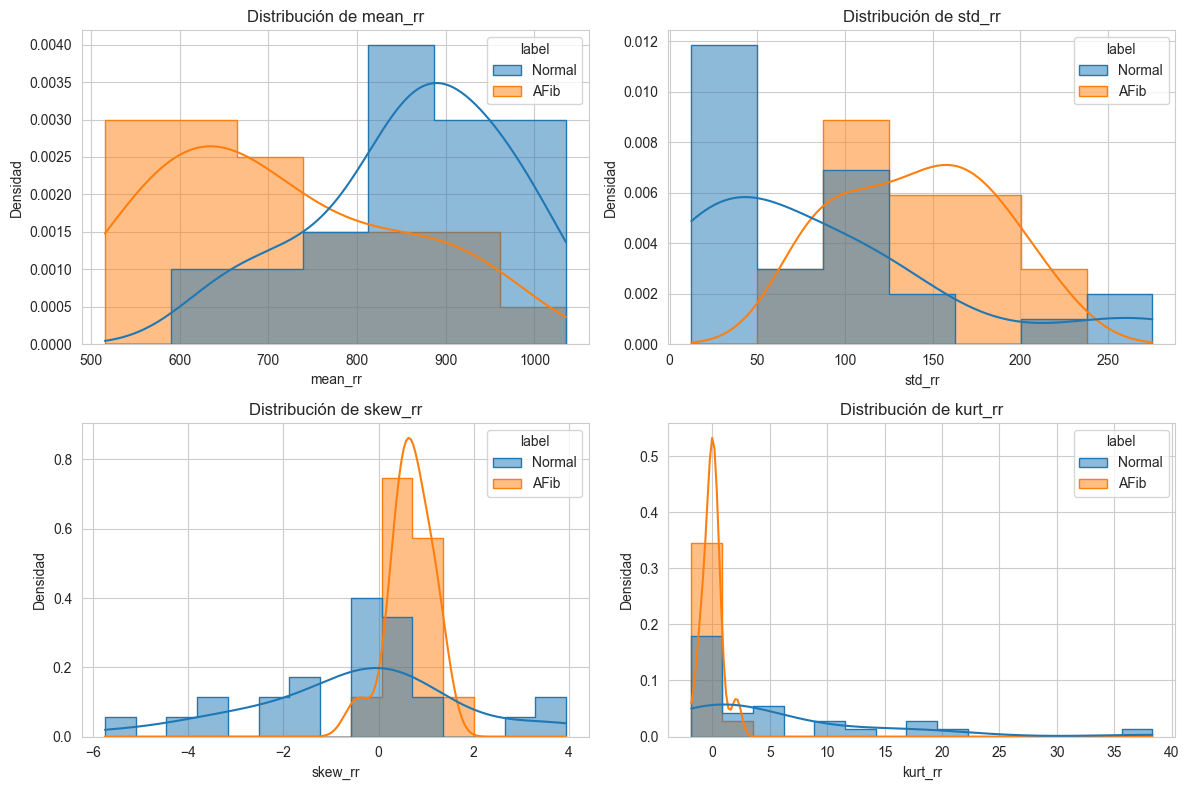

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# variables numéricas
features = ['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, var in zip(axes, features):
    sns.histplot(data=df,
                 x=var,
                 hue='label',
                 kde=True,
                 element='step',
                 stat='density',
                 common_norm=False,
                 alpha=0.5,
                 ax=ax)
    ax.set_title(f'Distribución de {var}')
    ax.set_ylabel('Densidad')

plt.tight_layout()
plt.show()


**Diagrama de caja**

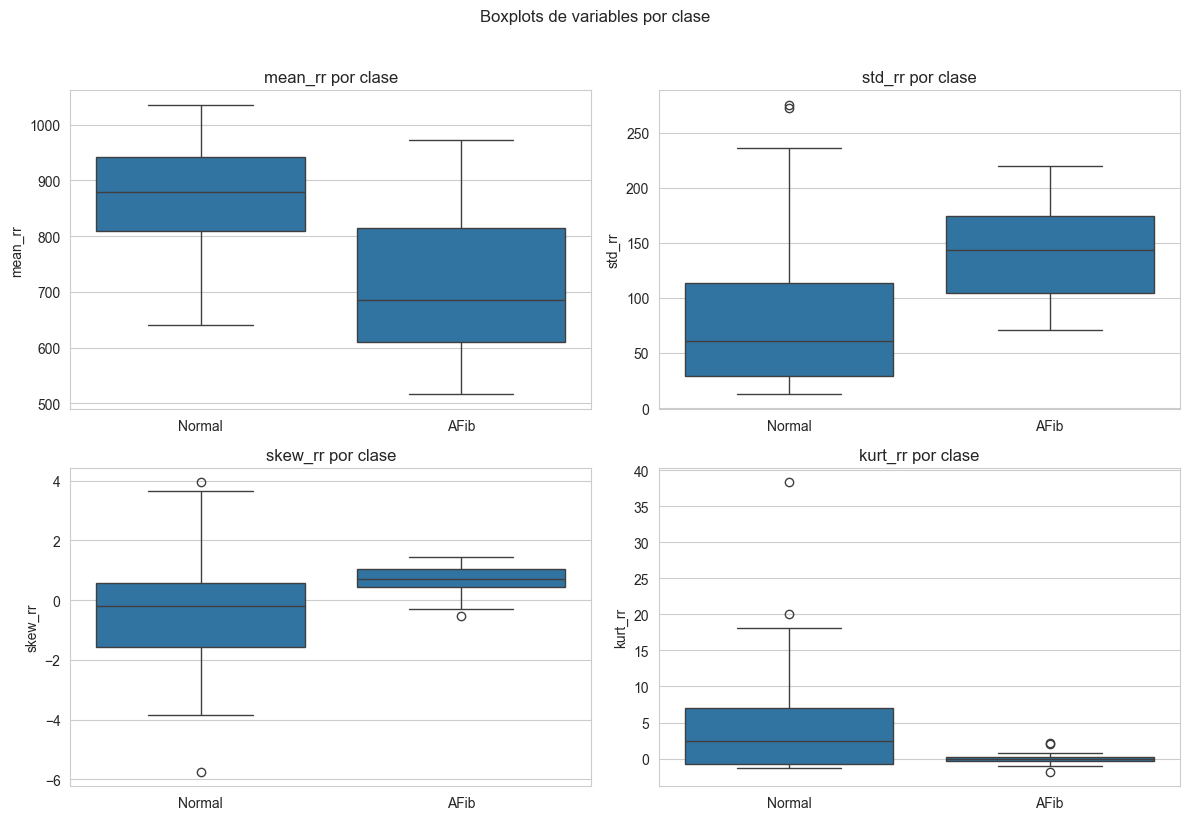

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, var in zip(axes, features):
    sns.boxplot(data=df, x='label', y=var, ax=ax)
    ax.set_title(f'{var} por clase')
    ax.set_xlabel('')   # quita texto redundante
plt.suptitle('Boxplots de variables por clase', y=1.02)
plt.tight_layout()
plt.show()




*   Histograma para --> Mostrar toda la forma de la distribución
*   Elemento de la lista --> Resumen de la mediana, rango y outliers



* mean_rr: 	Promedio del tiempo entre latidos. Más bajo = corazón más rápido
* std_rr: Qué tanto varían los tiempos entre latidos. Alta = latidos irregulares
* skew_rr: Si los intervalos están sesgados hacia más cortos o más largos
* kurt_rr: 	Qué tan “picuda” o concentrada es la distribución de RR. Alta = colas largas (variaciones extremas)

si no cambian mucho entre clases pues da la impresión de que muy útil no es

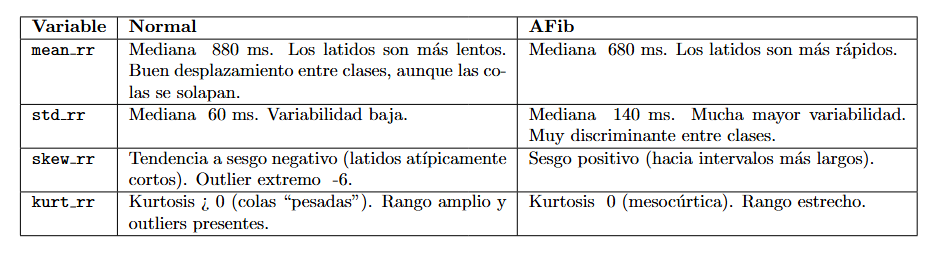

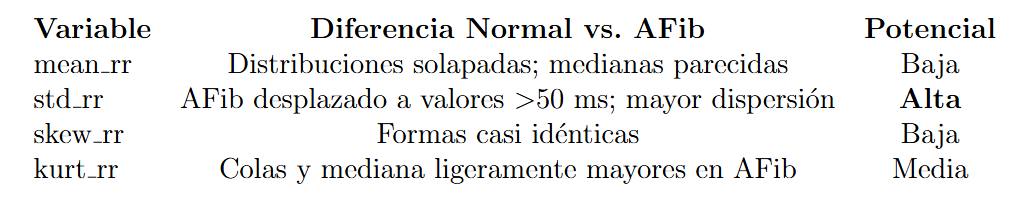


**¿Qué variables parecen diferenciar más entre clases?**




*   std_rr es la variable más discriminante: la media es considerablemente mayor en la clase AFib (aprox 54 ms) que en la clase Normal (aprox 41 ms)
* kurt_rr también muestra diferencias: valores ligeramente más altos en AFib
* mean_rr y skew_rr no parecen aportar demasiado





**¿Qué aspectos del dataset llaman la atención?**

- El dataset es pequeño
- No hay valores nulos
- Las variables estadísticas (mean, std, skew, kurt) permiten analizar la dinámica del ECG sin necesidad de procesar la señal cruda
- std_rr es la característica más discriminante